In [3]:
!pip install missingno

You should consider upgrading via the '/Users/karmasub/.pyenv/versions/3.9.11/bin/python3.9 -m pip install --upgrade pip' command.


In [4]:
!pip install lazypredict

You should consider upgrading via the '/Users/karmasub/.pyenv/versions/3.9.11/bin/python3.9 -m pip install --upgrade pip' command.


In [5]:
!pip install optuna scikit-learn

You should consider upgrading via the '/Users/karmasub/.pyenv/versions/3.9.11/bin/python3.9 -m pip install --upgrade pip' command.


In [6]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
import math
import optuna
import numpy as np

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [8]:
train.shape,test.shape

((8523, 12), (5681, 11))

<Axes: >

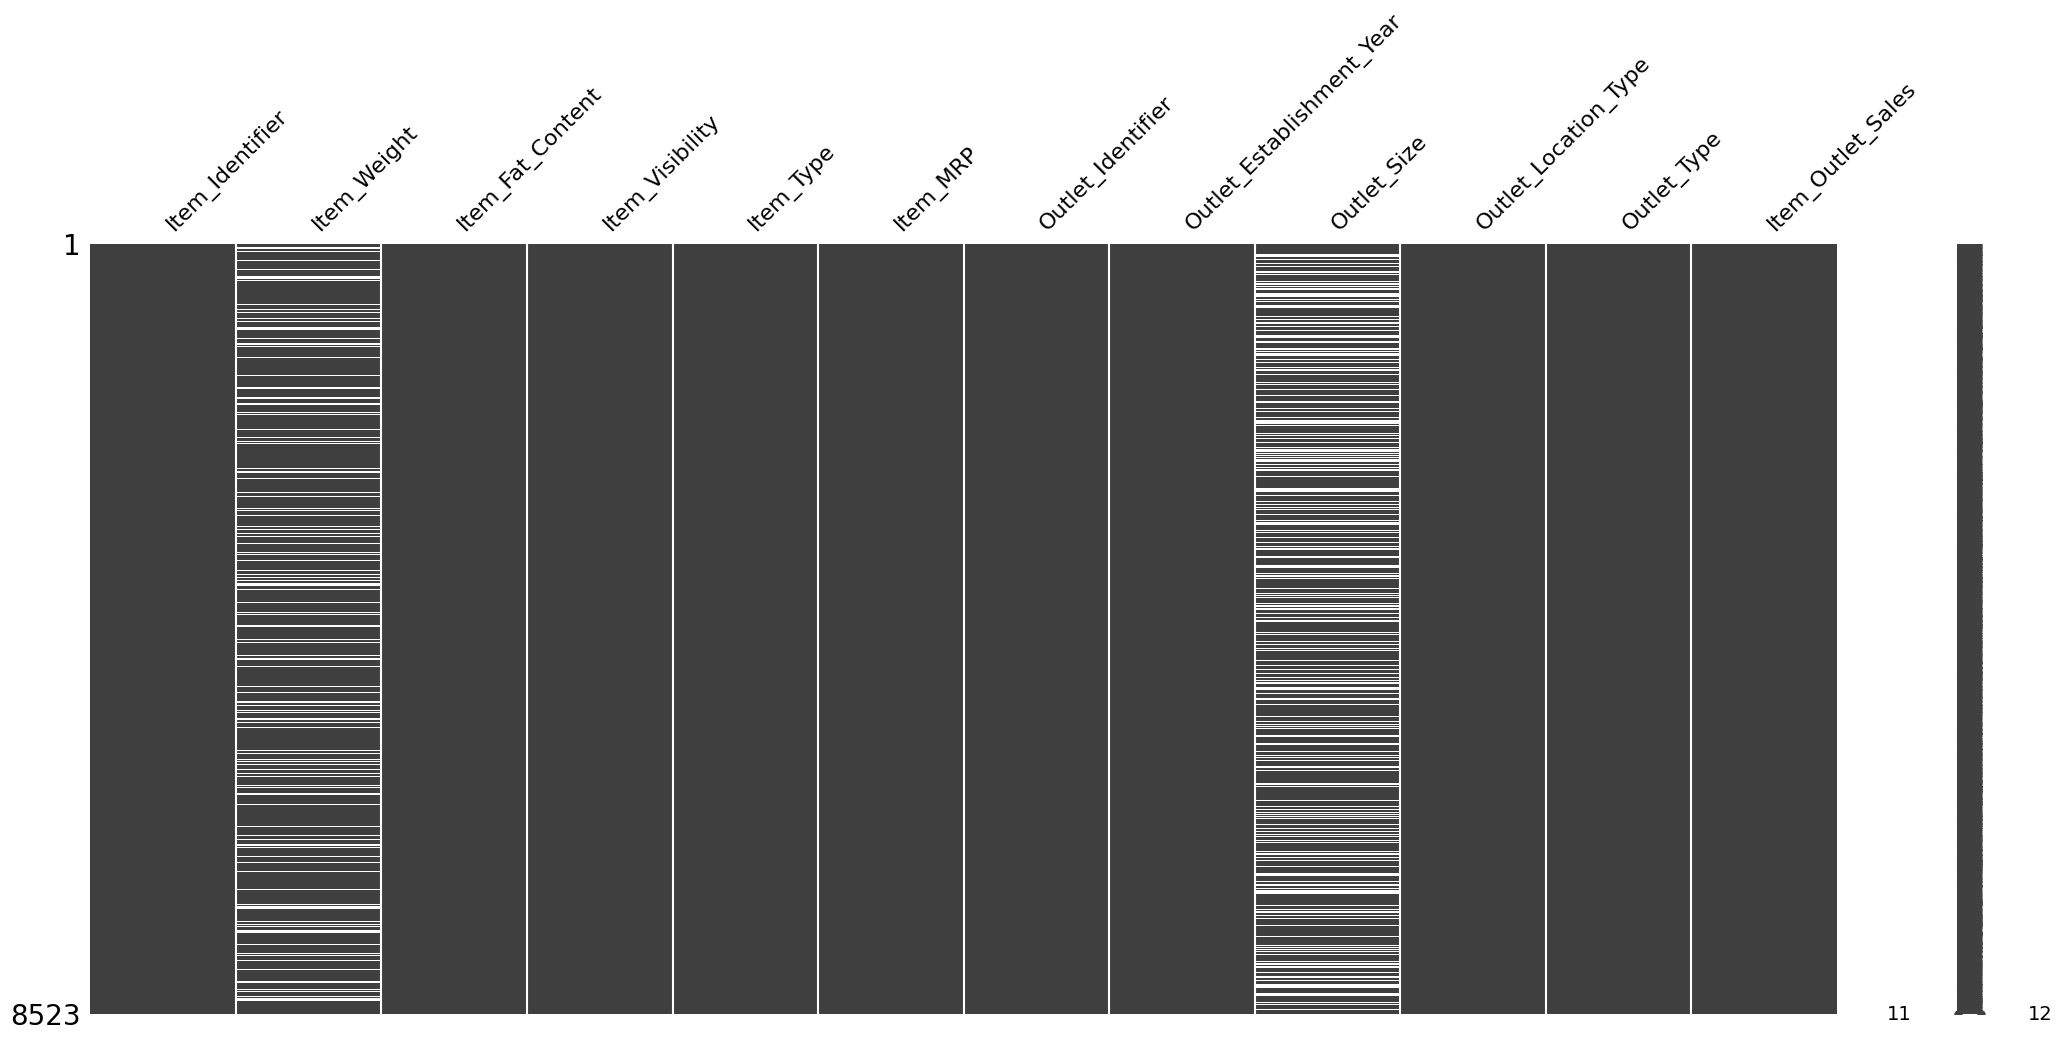

In [9]:
msno.matrix(train)

<Axes: >

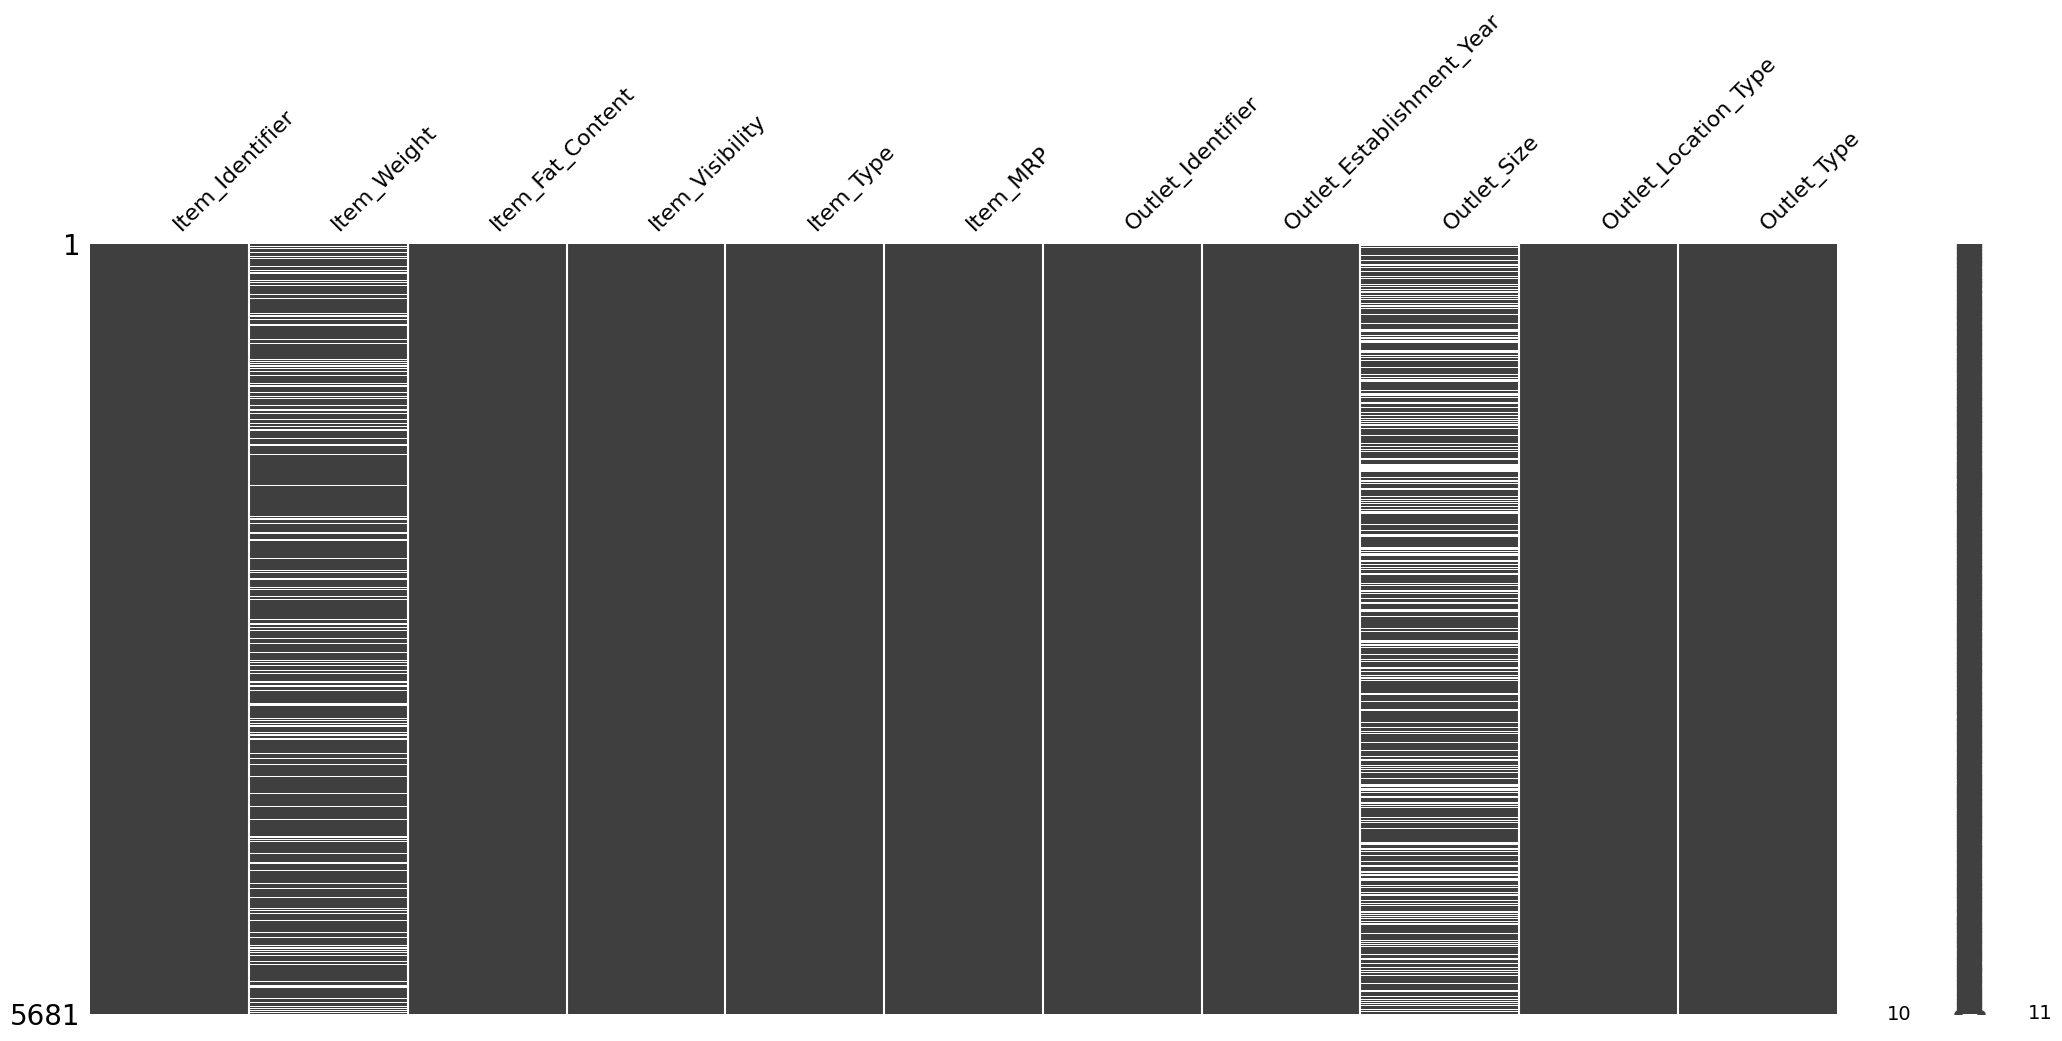

In [10]:
msno.matrix(test)

In [11]:
train.isnull().sum()/len(train)

Item_Identifier             0.00
Item_Weight                 0.17
Item_Fat_Content            0.00
Item_Visibility             0.00
Item_Type                   0.00
Item_MRP                    0.00
Outlet_Identifier           0.00
Outlet_Establishment_Year   0.00
Outlet_Size                 0.28
Outlet_Location_Type        0.00
Outlet_Type                 0.00
Item_Outlet_Sales           0.00
dtype: float64

In [12]:
train.head(30)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.14
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.27
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71
5,FDP36,10.39,Regular,0.00,Baking Goods,51.40,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.61
6,FDO10,13.65,Regular,0.01,Snack Foods,57.66,OUT013,1987,High,Tier 3,Supermarket Type1,343.55
7,FDP10,NaN,Low Fat,0.13,Snack Foods,107.76,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.76
8,FDH17,16.20,Regular,0.02,Frozen Foods,96.97,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.60
9,FDU28,19.20,Regular,0.09,Frozen Foods,187.82,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.53


***
1) We observed that 17% of Item Weight column and 28% of Outlet size column is having null values so we can easily impute them with mean/median.
2)  There is an association of Item_Identifier and Item Type in where FD is related to food items, NC-Non-Consumable,DR-Drinks
***


In [13]:
train['Item_Categories'] = train['Item_Identifier'].str[0:2] #.astype(int)
test['Item_Categories']  = test['Item_Identifier'].str[0:2]

# Univariate EDA  

## Numeric Columns

In [14]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.00,8523.00,8523.00,8523.00,8523.00
mean,12.86,0.07,140.99,1997.83,2181.29
std,4.64,0.05,62.28,8.37,1706.50
min,4.55,0.00,31.29,1985.00,33.29
25%,8.77,0.03,93.83,1987.00,834.25
50%,12.60,0.05,143.01,1999.00,1794.33
75%,16.85,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


In [15]:
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns.tolist()

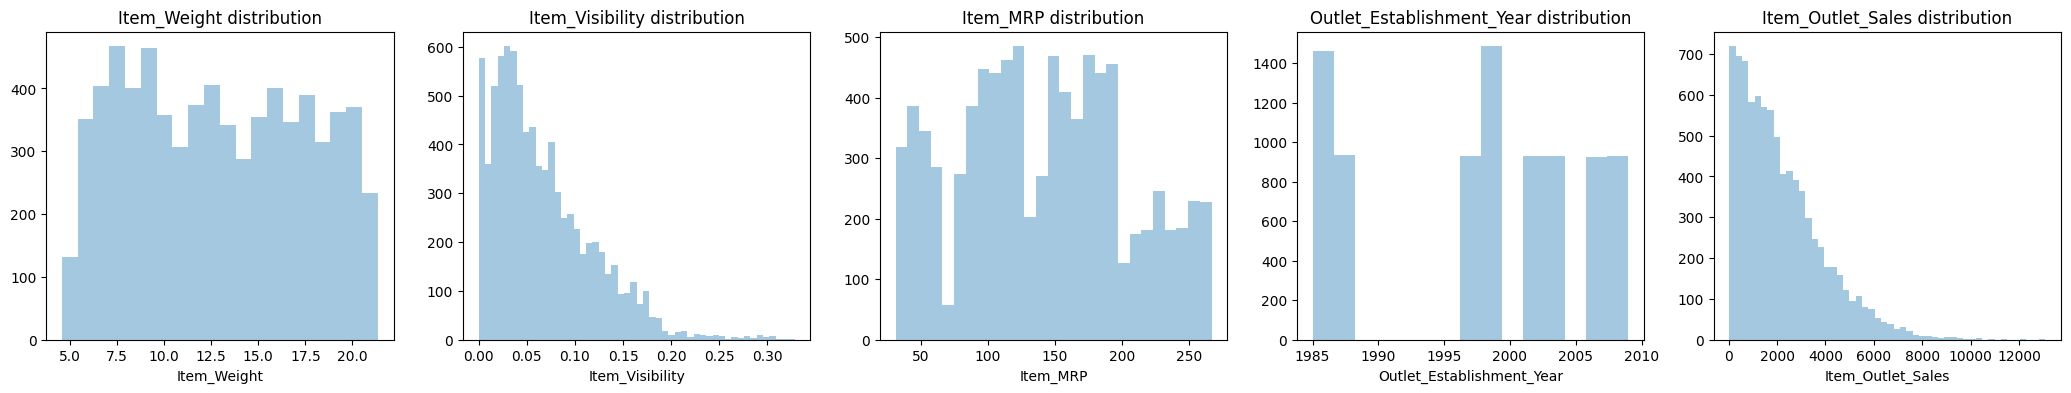

In [16]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(numeric_cols):
    sns.distplot(train[col], kde=False, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

*** 
Observations
1) Not all items are displayed equally.
2) for the year 1990 and 1995 no stores are opened.
3) Both item_visibility and itm_outlet_sales are rightly skewed as a result there would be a chance of outliers
   

## Categorical Columns

In [17]:
categorical_cols = ['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type']

In [18]:
for col in categorical_cols:
    print(f"Number of values in the {col} column is:\n{train[col].value_counts() }")
    print("--" * 30)

Number of values in the Item_Fat_Content column is:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
------------------------------------------------------------
Number of values in the Item_Type column is:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
------------------------------------------------------------
Number of values in the Outlet_Size column is:
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64
------------------------------

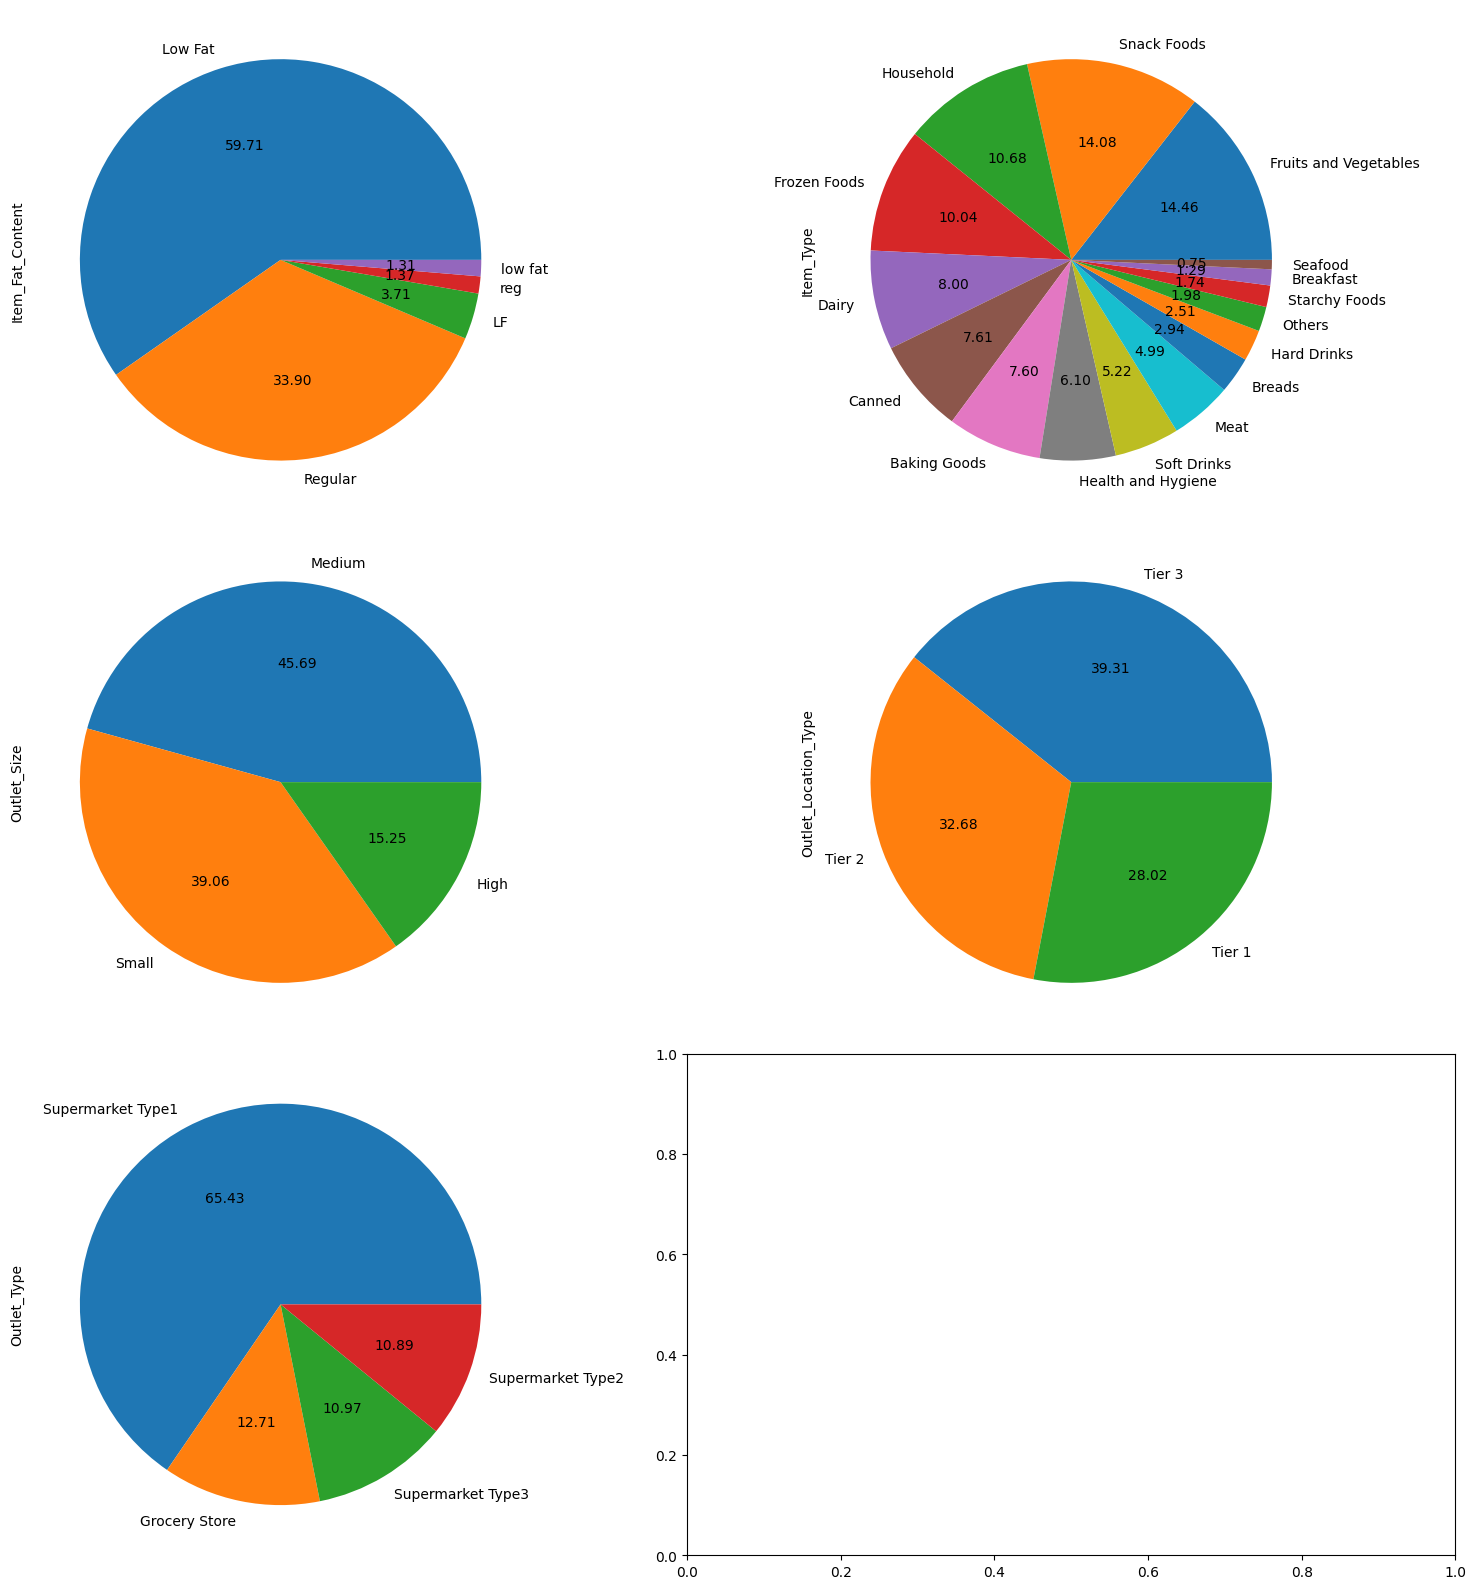

In [19]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))

for index, col in enumerate(categorical_cols):
    r = index // 2
    c = index % 2
    train[col].value_counts().plot(kind="pie", autopct="%.2f", ax=ax[r][c])
    #g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    #ax[r][c].set_title(f'{col} distribution', fontsize=24)
    plt.tight_layout()

*** Observations 
1) The Item_Fat_Content has categories which are duplicate and can be combined to have two categories low fat and regular fat.
2) The outlet location type like Tier 1, Tier 2 and Tier 3 can encoded into ordinal categories.
***

In [20]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})

In [21]:
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})

# Bivariate Analysis

## Continuous Variable And Target Variable

In [22]:
target = "Item_Outlet_Sales"

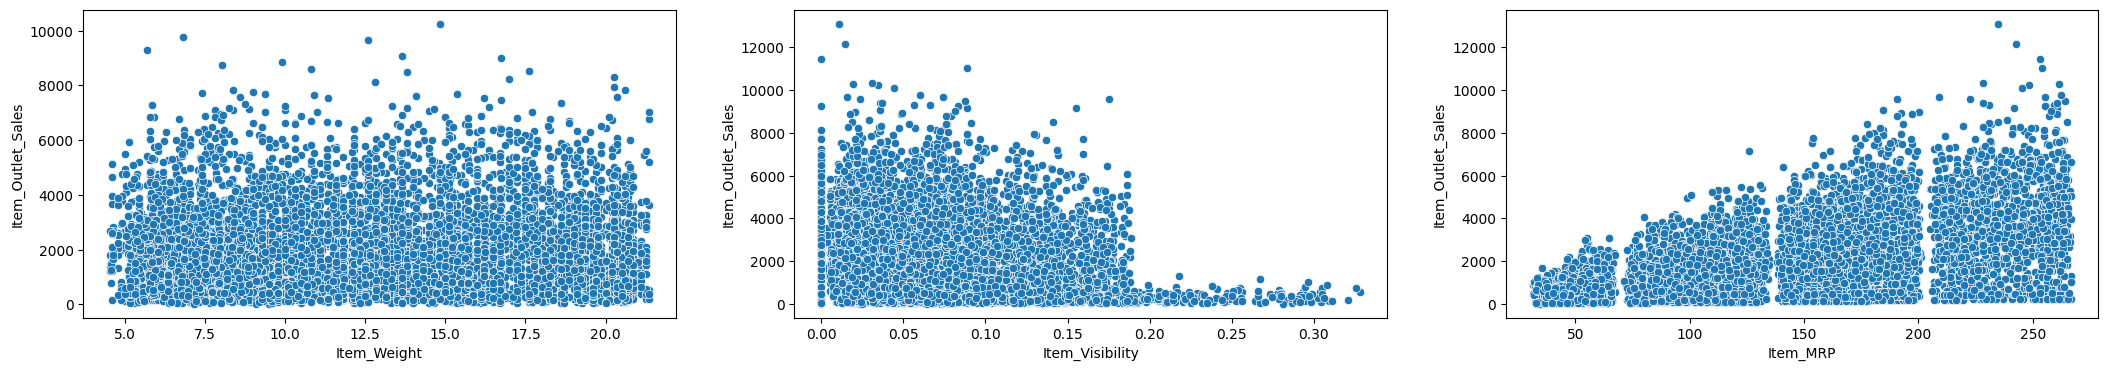

In [23]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP']):
    sns.scatterplot(data=train,x=col, y=target, ax=ax[index])

<Axes: >

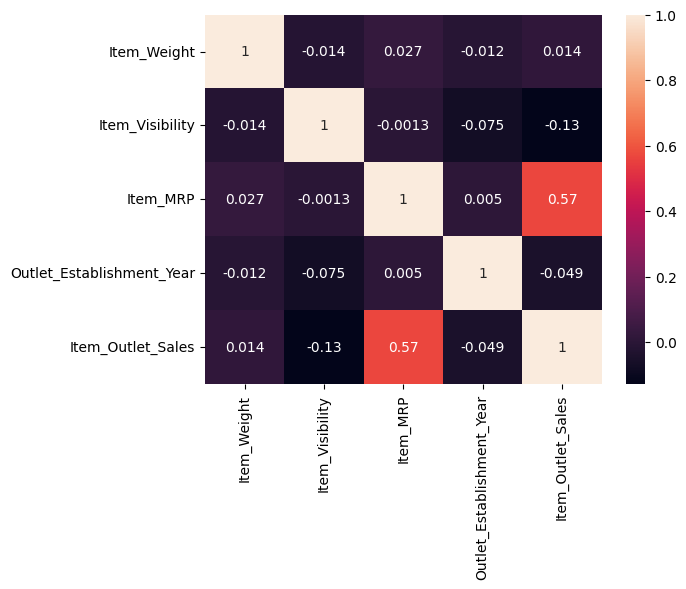

In [24]:
sns.heatmap(train.corr(), annot=True)

## Categorical and Target Variable


In [25]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Categories
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.14,FD
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42,DR
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.27,FD
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38,FD
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71,NC


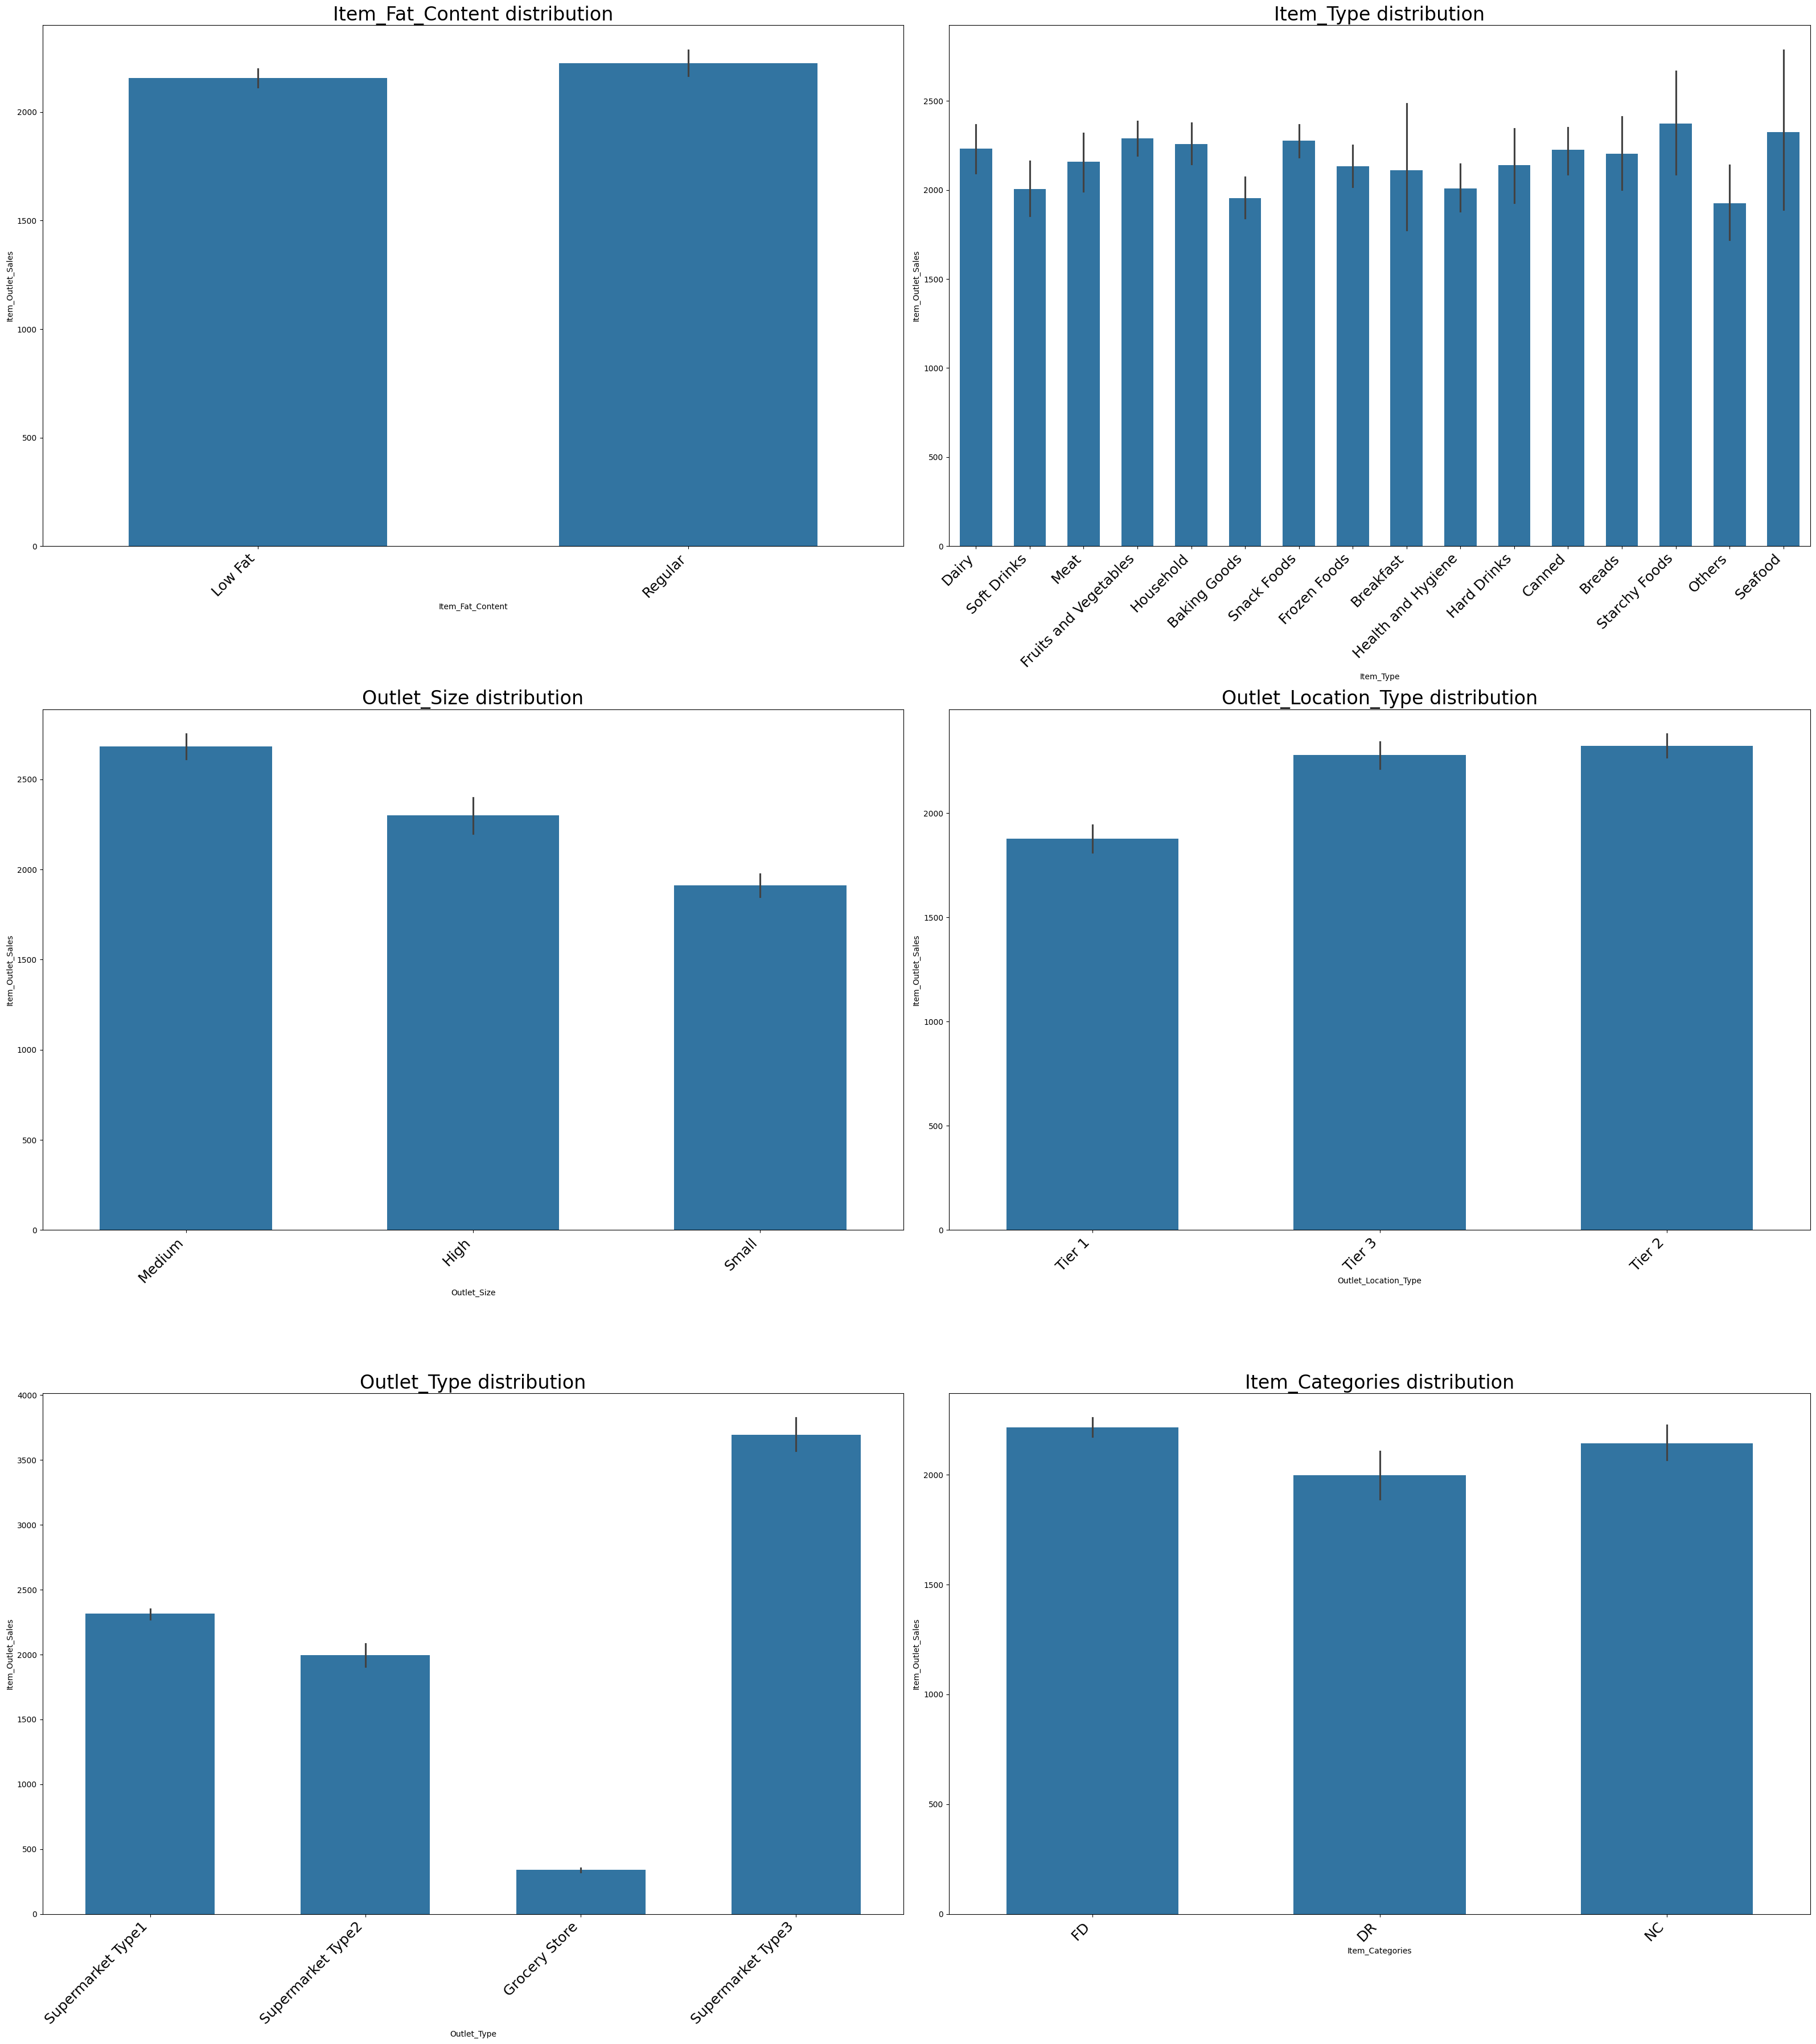

In [26]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(32, 36))
categorical_cols += ['Item_Categories']
for index, col in enumerate(categorical_cols):
    r = index // 2
    c = index % 2
    g = sns.barplot(data=train, x=col ,y=target, ax=ax[r][c], width=0.6)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    ax[r][c].set_title(f'{col} distribution', fontsize=24)
    plt.tight_layout()

*** 
Observations 
1) It seems that the outlet of Type 3 SuperMarket has the highest outlet sales wheras grocery store has the least 


## Missing Value Treatment

In [27]:
#filling the object values with mode and float type with mean

# for train
train['Outlet_Size'] = train.Outlet_Size.fillna(train.Outlet_Size.dropna().mode()[0]) #replace by the median after
train['Item_Weight'] = train.Item_Weight.fillna(train.Item_Weight.mean())

# for test
test['Outlet_Size'] = test.Outlet_Size.fillna(test.Outlet_Size.dropna().mode()[0]) #replace by the median after
test['Item_Weight'] = test.Item_Weight.fillna(test.Item_Weight.mean())

## Outlier Detection

Upper limit:  6501.8699
Lower limit:  -2566.3261


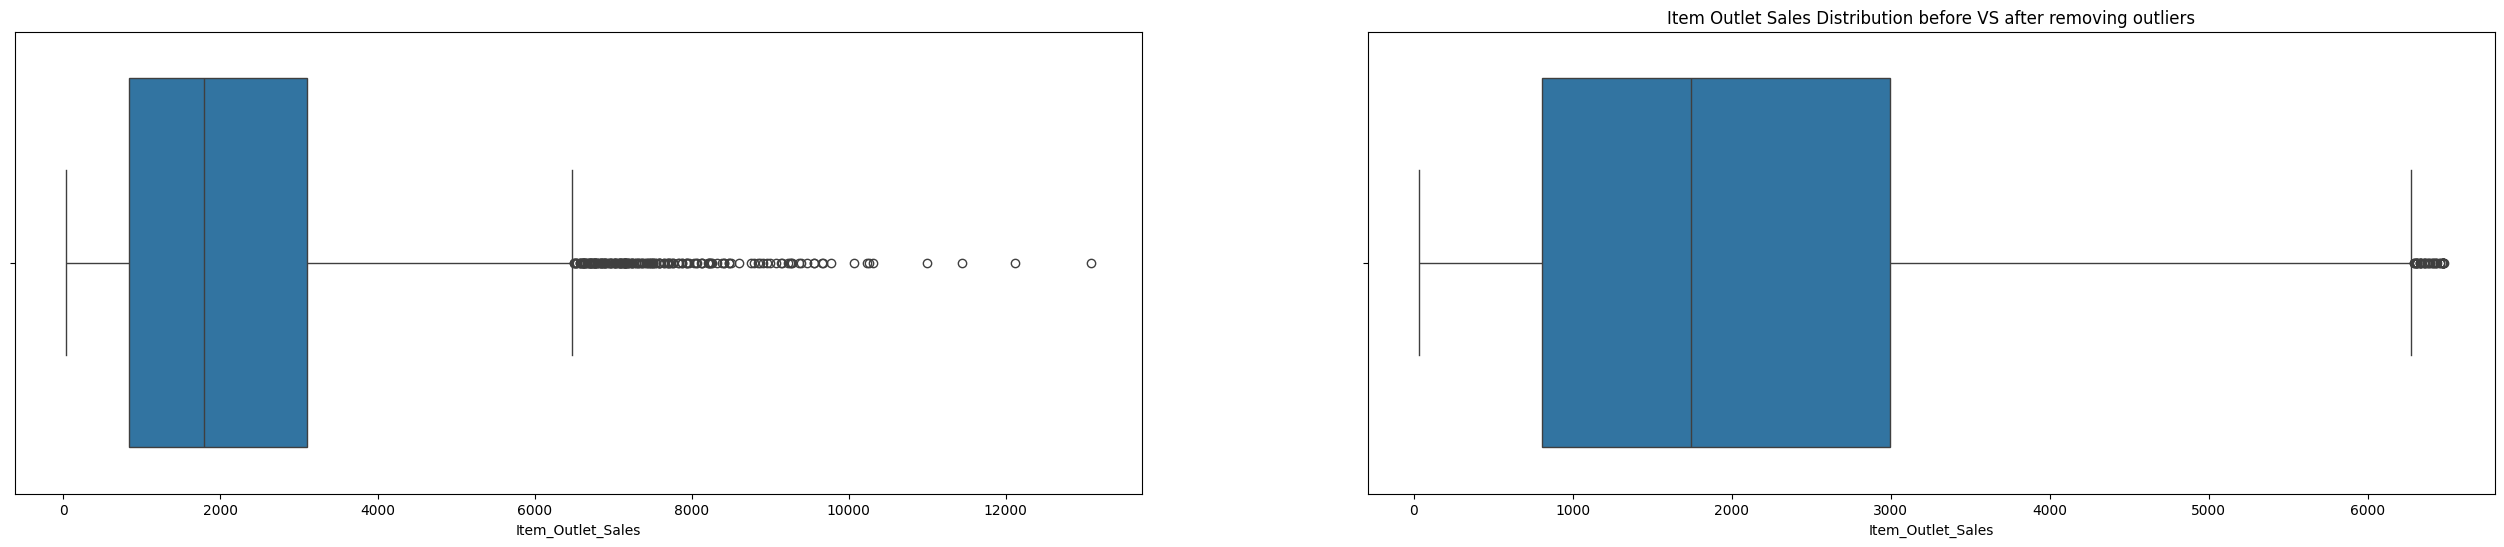

In [29]:

def detect_outliers(df, feature):
    Q1  = df[feature].quantile(0.25)
    Q3  = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

upper, lower = detect_outliers(train, "Item_Outlet_Sales")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 6))
sns.boxplot(x=train['Item_Outlet_Sales'], ax=ax[0])

# removing outliers from the sales variables
train = train[(train['Item_Outlet_Sales'] > lower) & (train['Item_Outlet_Sales'] < upper)]

sns.boxplot(x=train['Item_Outlet_Sales'], ax=ax[1])
plt.title('Item Outlet Sales Distribution before VS after removing outliers')
plt.show()

In [30]:
train['Item_Outlet_Sales'].describe()

count   8337.00
mean    2059.36
std     1506.10
min       33.29
25%      810.94
50%     1747.06
75%     2998.10
max     6478.23
Name: Item_Outlet_Sales, dtype: float64

## Encoding Categorical Variables

In [31]:
train['Outlet_Size'] = train['Outlet_Size'].map({'Small'  : 1,
                                                 'Medium' : 2,
                                                 'High'   : 3
                                                 }).astype(int)

test['Outlet_Size'] = test['Outlet_Size'].map({'Small'  : 1,
                                               'Medium' : 2,
                                               'High'   : 3
                                              }).astype(int)

<Axes: xlabel='Outlet_Size', ylabel='count'>

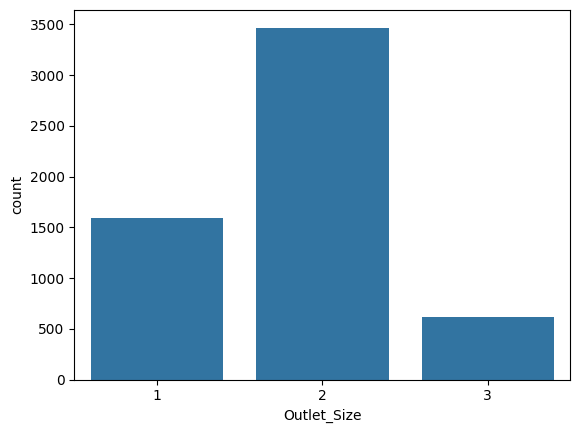

In [32]:
sns.countplot(x=test['Outlet_Size'])


In [33]:
train['Outlet_Location_Type'] = train['Outlet_Location_Type'].str[-1:].astype(int)
test['Outlet_Location_Type']  = test['Outlet_Location_Type'].str[-1:].astype(int)

In [34]:
encoder = LabelEncoder()
ordinal_features = ['Item_Fat_Content', 'Outlet_Type', 'Outlet_Location_Type']

for feature in ordinal_features:
    train[feature] = encoder.fit_transform(train[feature])
    test[feature]  = encoder.fit_transform(test[feature])

## One Hot Encoding

In [35]:
train = pd.get_dummies(train, columns=['Item_Type', 'Item_Categories', 'Outlet_Identifier'], drop_first=True)
test  = pd.get_dummies(test,  columns=['Item_Type', 'Item_Categories', 'Outlet_Identifier'], drop_first=True)

## PreProcessing Data

In [36]:
#Dropping useless columns
train.drop(labels=['Item_Identifier'], axis=1, inplace=True)
test.drop(labels=['Item_Identifier'],  axis=1, inplace=True)

## Model Selection

In [37]:
X = train.drop('Item_Outlet_Sales', axis=1)
y = train['Item_Outlet_Sales']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [39]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 814
[LightGBM] [Info] Number of data points in the train set: 6252, number of used features: 34
[LightGBM] [Info] Start training from score 2054.376487
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
GradientBoostingRegressor                    0.59       0.60   960.65   
MLPRegressor                                 0.58       0.59   974.45   
HistGradientBoostingRegressor                0.57       0.57   992.17   
PoissonRegressor                             0.57       0.57   992.36   
LassoCV                                      0.56       0.57   994.16   
LassoLarsCV                                  0.56       0.57   994.16   
LassoLars

* Based on the results above we are going to build the model using GradientBoostingRegressor 

## Model Building

In [40]:
from sklearn.ensemble import GradientBoostingRegressor 

In [41]:
gb_model = GradientBoostingRegressor(random_state=42)

In [42]:
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [43]:
# Predictions for XGBoost on the test data
gb_predictions = gb_model.predict(X_test)

In [44]:
print('GradientBoost Training score  : {}'.format(gb_model.score(X_train, y_train)))
print('GradientBoost Test score      : {}'.format(gb_model.score(X_test, y_test)))

GradientBoost Training score  : 0.6200313261882491
GradientBoost Test score      : 0.599151690537465


In [45]:
gb_mse = mean_squared_error(y_test , gb_predictions)
gb_rmse = math.sqrt(gb_mse)
gb_r2 = r2_score(y_test, gb_predictions)

print('GradientBoost RMSE  \t   ----> {}'.format(gb_rmse))
print('GradientBoost R2 Score   ----> {}'.format(gb_r2))

GradientBoost RMSE  	   ----> 960.6461915148898
GradientBoost R2 Score   ----> 0.599151690537465


## Hyper Parameter Tuning

In [46]:

# Define objective function for Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    }

    model = GradientBoostingRegressor(**params, random_state=42)

    # Use cross-validation for robust evaluation
    scores = cross_val_score(model, X_train, y_train, 
                             scoring="neg_mean_squared_error", 
                             cv=3, n_jobs=-1)
    rmse = np.sqrt(-scores.mean())
    return rmse


# Create and run study
study = optuna.create_study(direction="minimize")  # minimize RMSE
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Best Trial:")
print(study.best_trial.params)


# Train final model with best hyperparameters
best_model = GradientBoostingRegressor(**study.best_trial.params, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate on validation set
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Validation RMSE:", rmse)


[I 2025-09-01 21:10:46,017] A new study created in memory with name: no-name-954d3343-082c-4a85-9c59-e5e776fa6068
[I 2025-09-01 21:10:55,675] Trial 4 finished with value: 982.7969041514433 and parameters: {'n_estimators': 303, 'learning_rate': 0.016241547842126974, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 9, 'subsample': 0.5242125154406563, 'max_features': 'log2'}. Best is trial 4 with value: 982.7969041514433.
[I 2025-09-01 21:10:55,832] Trial 2 finished with value: 986.6706706318649 and parameters: {'n_estimators': 488, 'learning_rate': 0.018819305646486963, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 2, 'subsample': 0.7172078655559009, 'max_features': 'sqrt'}. Best is trial 4 with value: 982.7969041514433.
[I 2025-09-01 21:10:55,870] Trial 3 finished with value: 991.1400028032792 and parameters: {'n_estimators': 154, 'learning_rate': 0.05156210624999687, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 2, 'subsample': 0.678957112648105

Best Trial:
{'n_estimators': 502, 'learning_rate': 0.013202579528043963, 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 11, 'subsample': 0.7695326328913936, 'max_features': None}
Validation RMSE: 953.8240084932854


## Fitting the final model

In [47]:
best_model = GradientBoostingRegressor(**study.best_trial.params, random_state=42)

In [48]:

best_model.fit(X, y)

GradientBoostingRegressor(learning_rate=0.013202579528043963, max_depth=2,
                          min_samples_leaf=11, min_samples_split=18,
                          n_estimators=502, random_state=42,
                          subsample=0.7695326328913936)

## Test Data Predictions

In [49]:
test_preds = gb_model.predict(test)

In [50]:
len(test_preds)

5681

In [51]:
test_submission = pd.read_csv('test.csv')

In [52]:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']

In [53]:
test_submission = test_submission[IDcol]
test_submission

,Item_Identifier,Outlet_Identifier
0,FDW58,OUT049
1,FDW14,OUT017
2,NCN55,OUT010
3,FDQ58,OUT017
4,FDY38,OUT027
...,...,...
5676,FDB58,OUT046
5677,FDD47,OUT018
5678,NCO17,OUT045
5679,FDJ26,OUT017


In [54]:
test_submission['Item_Outlet_Sales'] = test_preds

In [55]:
test_submission

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1622.77
1,FDW14,OUT017,1284.89
2,NCN55,OUT010,749.59
3,FDQ58,OUT017,2480.66
4,FDY38,OUT027,4450.98
...,...,...,...
5676,FDB58,OUT046,2188.02
5677,FDD47,OUT018,2559.67
5678,NCO17,OUT045,1816.73
5679,FDJ26,OUT017,3546.91


In [56]:
test_submission.to_csv('adboost.csv', index=False)